# Clustering using Hidden Markov Model 

### Import packages

In [1]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from hmmlearn import hmm
from simpl_eeg import (
    connectivity,
    eeg_objects,
    raw_voltage,
    topomap_2d,
    topomap_3d_brain,
    topomap_3d_head,
)

In [2]:
%matplotlib inline

### Plotting function

In [3]:
# Adapted from MDS 563 lecture 2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def plot_pca_clusters(data, labels):
    """
    Carries out dimensionality reduction on the data for visualization
    """
    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(
        data=principal_comp, columns=["pca1", "pca2"], index=data.index
    )
    pca_df["cluster"] = labels
    plt.figure(figsize=(6, 4))
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10"
    )
    plt.show()

In [4]:
import mne
import plotly.graph_objects as go
from scipy.interpolate import NearestNDInterpolator

def frame_args(duration):
    """Return the frame arguments of the animated plot

    Args:
        duration (int): The number of time stamps for the animated plot

    Returns:
        dict: A dictionary of frame arguments
    """
    return {
        "frame": {"duration": duration},
        "mode": "immediate",
        "fromcurrent": True,
        "transition": {"duration": duration, "easing": "linear", "redraw": False},
    }

def interpolated_time(df, channel_names, node_coord, x, y, z, t):
    """The function to animate the 3D plot

    Args:
        df (dataframe): A dataframe that contains the EEG signal of each electrodes for each time stamps
        channel_names (list): A list of channel names
        node_coord (array): A numpy array of (x, y, z) coordinates of all nodes
        x (array): A numpy array of X coordinates of all nodes for interpolation
        y (array): A numpy array of Y coordinates of all nodes for interpolation
        z (array): A numpy array of Z coordinates of all nodes for interpolation
        t (int): The time stampe we want to interpolate EEG voltages for

    Returns:
        array: A numpy array of interpolated EEG voltages
    """
    # get the EEG data for a specific time stamp
    now = df[df["time"] == t]
    # slice the dataframe to only include EEG signals of each electrodes
    eeg = now.loc[:, channel_names].mean().values
    # build the interpolation model using NearestNDInterpolator
    interpolate_model = NearestNDInterpolator(node_coord, eeg)
    return interpolate_model(np.array(list(zip(x, y, z))))


def get_eeg_node(raw, standard_montage_list):
    """Get the electrode location from the raw data

    Args:
        raw (dataframe): The raw dataframe
        standard_montage_list (array): The numpy array which contains the cartesian coordinate of standard node location

    Returns:
        array: The electrode location from the raw data
    """
    node_list = []
    for channel in raw.get_montage().ch_names:
        node_list.append(
            standard_montage_list.get_positions()["ch_pos"][channel].tolist()
        )
    node_coord = np.array(node_list)
    return node_coord


def get_node_dataframe(raw, montage):
    """Get the electrode name and electrode location from the raw data and save it in a dataframe

    Args:
        raw (dataframe): The raw dataframe
        montage (array): The numpy array which contains the cartesian coordinate of standard node location

    Returns:
        dataframe: A dataframe which contains the electrode name and electrode location from the raw data
    """
    node_list_name = []
    for channel in raw.get_montage().ch_names:
        node_list_name.append(
            [
                channel,
                montage.get_positions()["ch_pos"][channel][0],  # x value
                montage.get_positions()["ch_pos"][channel][1],  # y value
                montage.get_positions()["ch_pos"][channel][2],  # z value
            ]
        )
    node_df = pd.DataFrame(node_list_name, columns=["channel", "X", "Y", "Z"])
    return node_df

def get_standard_coord():
    """Generate an array of cartesian coordinates of the standard node locations ("standard_1005")

    Returns:
        array: A numpy array of cartesian coordinates of the standard node locations ("standard_1005")
    """
    # get the dictionary of standard montage "standard_1005"
    montage = mne.channels.make_standard_montage("standard_1005")
    standard_coord_list = []
    # get the cartesian coordinates from the standard montage dictionary
    for key, value in montage.get_positions()["ch_pos"].items():
        standard_coord_list.append(value.tolist())
    # save the cartesian coordinates in a numpy array
    standard_coord_array = np.array(standard_coord_list)
    return montage, standard_coord_array

def animate_3d_head(epoch, df, plot_title="", color_title="EEG MicroVolt", color_min = -50, color_max = 50, colormap="Bluered"):
    """Plot an animated topographic map in a 3D head shape

    Args:
        df (df): An epoched file for the EEGLab data
        plot_title (str, optionl): The title of the plot. Defaults to "".
        color_title (str,  optional): The title of the color bar. Defaults to "EEG MicroVolt".
        color_min (int, optional): The minimum EEG voltage value to be shown on the color bar. Defaults to -50.
        color_max (int, optional): The maximum EEG voltage value to be shown on the color bar. Defaults to 50.
        colormap (str, optional): The colour scheme to use. Defaults to Bluered.

    Returns:
        figure: An animated topographic map in a 3D head shape
    """
    
    

    # find out the channel names
    channel_names = epoch.ch_names

    # change the raw epoched data to a dataframe
    nb_frame=len(df)

    # get the standard montage coordinates
    standard_montage, standard_coord = get_standard_coord()
    x = np.array(standard_coord)[:, 0]
    y = np.array(standard_coord)[:, 1]
    z = np.array(standard_coord)[:, 2]

    # get the coordinated of the electrodes in the raw data
    node_coord = get_eeg_node(epoch, standard_montage)
    node_df = get_node_dataframe(epoch, standard_montage)

    # generate the animated plot
    fig = go.Figure(
        frames=[
            go.Frame(
                data=go.Mesh3d(
                    x=np.array(standard_coord)[:, 0],
                    y=np.array(standard_coord)[:, 1],
                    z=np.array(standard_coord)[:, 2],
                    colorscale=colormap,
                    colorbar_title=color_title,
                    cmin=color_min,
                    cmax=color_max,
                    intensity=interpolated_time(
                        df, channel_names, node_coord, x, y, z, k
                    ),
                    intensitymode="vertex",
                    alphahull=1,
                    opacity=1,
                )
                ,
                name=str(k),  # you need to name the frame for the animation to behave properly
            )
            for k in df.time
        ]
    )
    
    starting_time = df.iloc[0, 0]
    # add data to be displayed before animation starts
    fig.add_trace(
        go.Mesh3d(
            x=np.array(standard_coord)[:, 0],
            y=np.array(standard_coord)[:, 1],
            z=np.array(standard_coord)[:, 2],
            colorscale=colormap,
            colorbar_title=color_title,
            cmin=color_min,
            cmax=color_max,
            intensity=interpolated_time(df, channel_names, node_coord, x, y, z, starting_time),
            intensitymode="vertex",
            alphahull=1,
            opacity=1,
        )
    )

    # add the 3D scatter plot for the electrodes of the raw data
    fig.add_scatter3d(
        connectgaps=True,
        x=node_df["X"],
        y=node_df["Y"],
        z=node_df["Z"],
        text=node_df["channel"],
        mode="markers+text",
        marker={"size": 5, "color": "black"},
        textposition="top center",
        textfont=dict(family="sans serif", size=18),
    )
    

    # set up slider for the animated plot
    sliders = [
        {
            "pad": {"b": 0, "t": 0},
            "len": 0.9,
            "x": 0.1,
            "y": 0,
            "currentvalue":{"prefix": "Time stamp : ", "visible": True, "xanchor":"center"},
            "steps": [
                {
                    "args": [[f.name], frame_args(0)],
                    "label": f.name,
                    "method": "animate",
                }
                for k, f in enumerate(fig.frames)
            ],
            'transition': {'duration': 0, 'easing': 'linear'},
        }
    ]

    fig.update_layout(
        title=plot_title,
        width=1000,
        height=600,
        scene=dict(
            aspectratio=dict(x=1.5, y=1.5, z=1),
        ),
        updatemenus=[
            {
                "buttons": [
                    {
                        "args": [None, frame_args(0)],
                        "label": "Play",  # play symbol
                        "method": "animate",
                    },
                    {
                        "args": [[None], frame_args(0)],
                        "label": "Pause",  # pause symbol
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 1, "t": 1},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
        ],
        sliders=sliders,
        transition=dict(duration=0, easing="linear")
    )
    return fig

### Read in the data

In [5]:
raw_full = mne.io.read_raw_eeglab("../../data/927/fixica.set")

Reading C:\Users\Yiki\Documents\UBC\MDS\Homework\capstone\simpl_eeg_capstone\data\927\fixica.fdt


<ipython-input-5-99b5e4cf8c83>:1: RuntimeWarning: Data file name in EEG.data (927 fix ica correct.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  raw_full = mne.io.read_raw_eeglab("../../data/927/fixica.set")


In [6]:
entire_df = raw_full.to_data_frame()

In [7]:
channel_names=raw_full.ch_names

### Data preprocessing

In [8]:
# to get average chunked data

cleaned_df = entire_df.loc[(entire_df[channel_names] != 0).all(axis=1)] # drop rows where all values are zero

df_no_outliers = cleaned_df.loc[((cleaned_df[channel_names] <=50) & (cleaned_df[channel_names] >= -50)).all(axis=1)].groupby("time").mean().reset_index()

sliced_col = int((len(df_no_outliers))/(2048*5))

avg_chunked_list = []
for i in range(sliced_col):
    avg_sliced_array = (
        df_no_outliers.iloc[i * 10240 : i * 10240 + 10240, 1:].mean().to_numpy()
    )  # separate the data into chunks of per 5 seconds and get the average
    avg_chunked_list.append(avg_sliced_array)
avg_chunked_array = np.array(avg_chunked_list)

In [ ]:
# round(df_no_outliers.describe(), 3)

In [ ]:
# to get chunk data, not used since file is too large and the operation runs out of memory

# avg_df = entire_df.groupby("time").mean().reset_index()
# entire_list = []
# for i in range(541):
#     sliced_array = avg_df.iloc[i*10000:i*10000+10000, 1:].to_numpy().reshape(-1)
#     entire_list.append(sliced_array)
# entire_array_chunk = np.array(entire_list)

# entire_array_chunk=np.float32(entire_array_chunk)

## Remove outliers

In [9]:
centered_model = hmm.GaussianHMM(n_components=4)

In [10]:
centered_model.fit(avg_chunked_array)

GaussianHMM(n_components=4)

In [11]:
centered_result = centered_model.decode(avg_chunked_array, algorithm="viterbi")

In [12]:
result_on_outlier = df_no_outliers.copy()
for index, labels in enumerate(centered_result[1]):
    result_on_outlier.loc[index * 10240 : index * 10240 + 10240, "cluster"] = labels

In [13]:
result_df_outlier=result_on_outlier.dropna()

In [14]:
cluster_array = np.array(result_df_outlier.cluster)

In [15]:
change_index = np.where(cluster_array[:-1] != cluster_array[1:])[0]

In [87]:
first_batch = result_df_outlier.iloc[:change_index[0] , :20]

In [83]:
second_batch = result_df_outlier.iloc[change_index[0]+1:change_index[1]+1, :20]

In [88]:
transition_10239 = animate_3d_head(raw_full, first_batch, plot_title='Cluster 3')

In [89]:
transition_10239.write_html("transition10239.html")

In [85]:
transition_20479 = animate_3d_head(raw_full, second_batch, plot_title='Cluster 2')

In [86]:
transition_20479.write_html("transition20479.html")

In [91]:
small=animate_3d_head(raw_full, first_batch.iloc[:30], plot_title='Cluster 3')

C:\Users\Yiki\miniconda3\envs\capstone\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


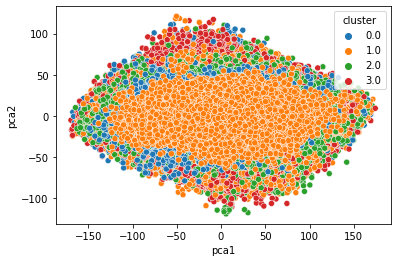

In [26]:
pca_no_outlier=plot_pca_clusters(result_df_outlier.iloc[:, 1:20], result_df_outlier.cluster)

In [27]:
df_sub_no_outlier = {}
for i in range(19):
    df_sub_no_outlier[i] = result_df_outlier[result_df_outlier['cluster'] == i].iloc[:, 1:20]

<ipython-input-30-68154a67d886>:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_no_outlier.show()


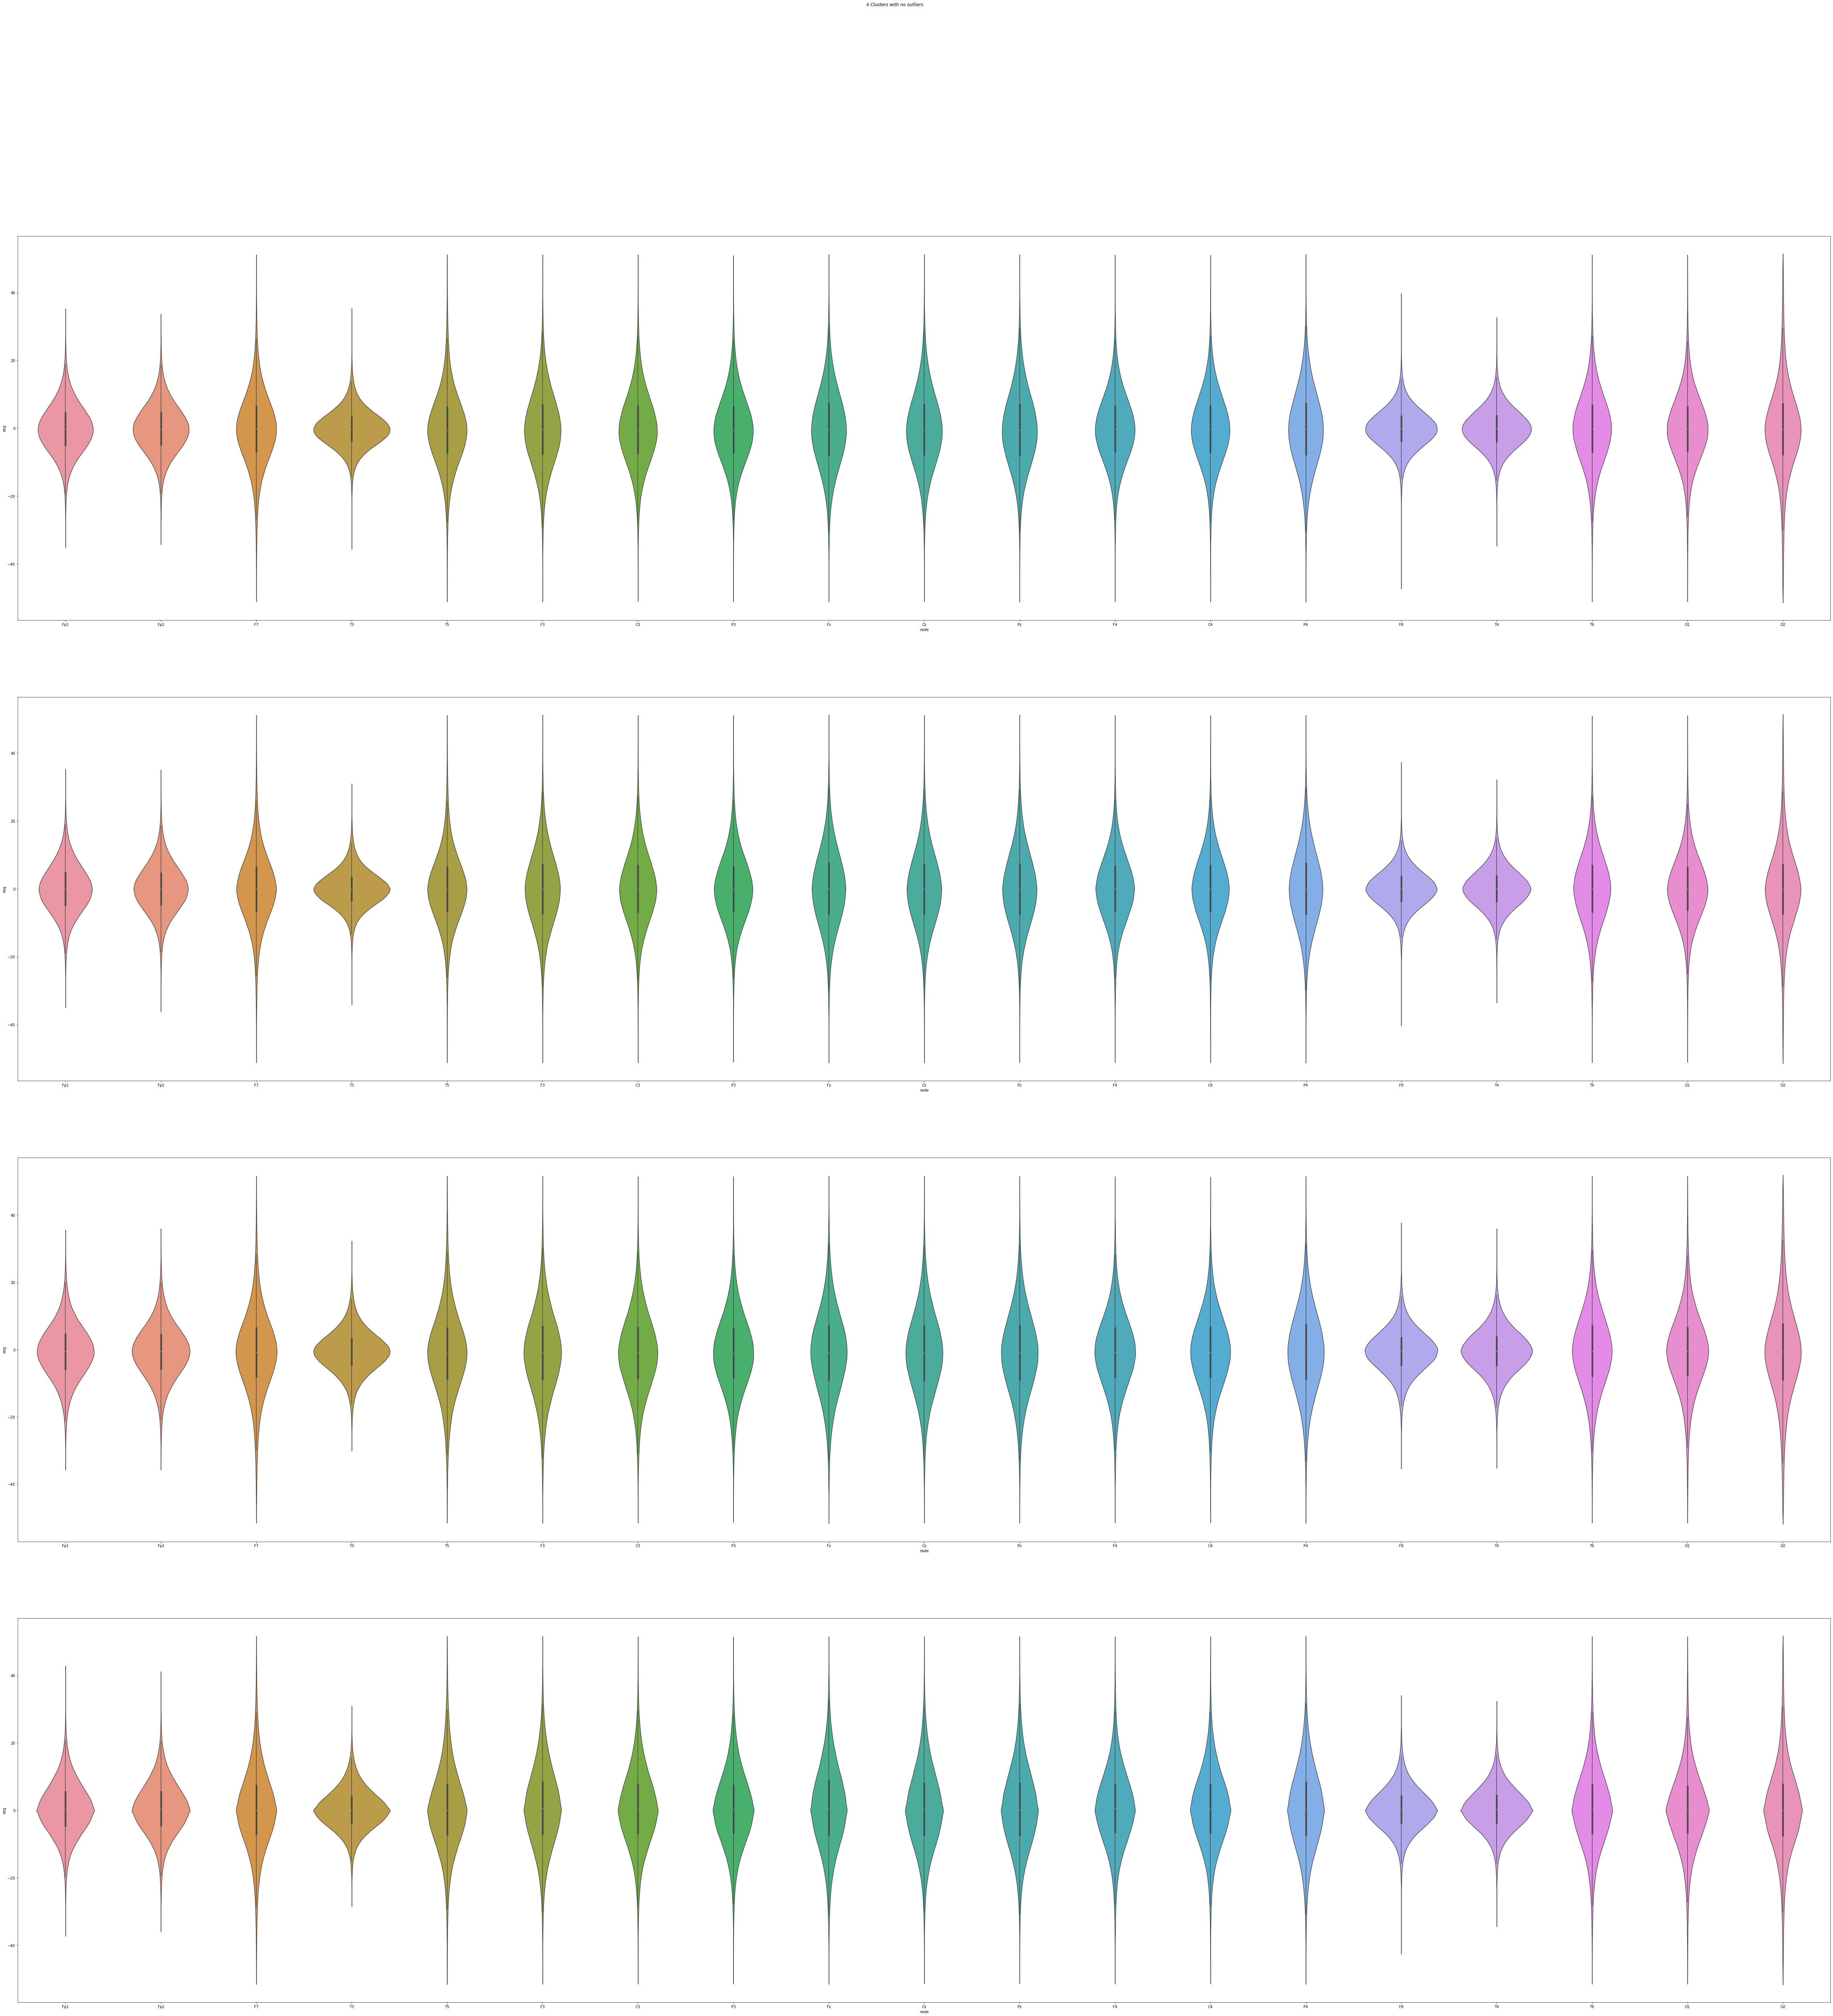

In [30]:
fig_no_outlier, axes_no_outlier = plt.subplots(nrows=4, ncols=1, figsize=(90, 90))
fig_no_outlier.suptitle('4 Clusters with no outliers')

for i, ax in enumerate(axes_no_outlier.flatten()):
    sns.violinplot(x="node", y="eeg", data=df_sub_no_outlier[i].melt(var_name="node", value_name="eeg"), ax=ax)

fig_no_outlier.show()

### Hyperparameter tuning

In [ ]:
tune_comp = {}
model_list = []
for n_comp in range(5, 21, 1):
    model = hmm.GaussianHMM(n_components=n_comp)
    model_list.append(model)
    model.fit(avg_chunked_array)
    result = model.decode(avg_chunked_array, algorithm="viterbi")
    tune_comp[n_comp] = result[0]

In [ ]:
maximum = max(tune_comp, key=tune_comp.get)
print(
    f"The best # of cluster is {maximum}, with log probability of {tune_comp[maximum]}"
)

### Model fitting

In [ ]:
model19 = model_list[14]
model19

In [ ]:
result19 = model19.decode(avg_chunked_array, algorithm="viterbi")

In [ ]:
result_df19 = sliced_df.copy()
for index, labels in enumerate(result19[1]):
    result_df19.loc[index * 10000 : index * 10000 + 10000, "cluster"] = labels

In [ ]:
model20 = model_list[-1]
model20

In [ ]:
result20 = model20.decode(avg_chunked_array, algorithm="viterbi")

In [ ]:
result_df20 = sliced_df.copy()
for index, labels in enumerate(result20[1]):
    result_df20.loc[index * 10000 : index * 10000 + 10000, "cluster"] = labels

### PCA 

In [ ]:
pca19=plot_pca_clusters(result_df19.iloc[:, 1:20], result_df19.cluster)
pca20=plot_pca_clusters(result_df20.iloc[:, 1:20], result_df20.cluster)

### Correlation

In [ ]:
df_corr19 = {}
for i in range(19):
    df_corr19[i] = result_df19[result_df19['cluster'] == i].iloc[:, 1:20].corr()

In [ ]:
df_corr20 = {}
for i in range(20):
    df_corr20[i] = result_df20[result_df20['cluster'] == i].iloc[:, 1:20].corr()

In [ ]:
# Set figsize here
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(30, 30))

for i, ax in enumerate(axes.flatten()[:19]):
    sns.heatmap(df_corr19[i], ax=ax)

fig.show()

In [ ]:
fig1, axes1 = plt.subplots(nrows=7, ncols=3, figsize=(30, 30))
fig1.suptitle('20 Clusters')

for i, ax in enumerate(axes1.flatten()[:20]):
    sns.heatmap(df_corr20[i], ax=ax)

fig1.show()

### Violin plot

In [ ]:
df_sub19 = {}
for i in range(19):
    df_sub19[i] = result_df19[result_df19['cluster'] == i].iloc[:, 1:20]

In [ ]:
df_sub20 = {}
for i in range(20):
    df_sub20[i] = result_df20[result_df20['cluster'] == i].iloc[:, 1:20]

In [ ]:
%matplotlib inline

In [ ]:
fig2, axes2 = plt.subplots(nrows=19, ncols=1, figsize=(90, 90))
fig2.suptitle('19 Clusters')

for i, ax in enumerate(axes2.flatten()[:19]):
    sns.violinplot(x="node", y="eeg", data=df_sub19[i].melt(var_name="node", value_name="eeg"), ax=ax)

fig2.show()

In [ ]:
fig3, axes3 = plt.subplots(nrows=20, ncols=1, figsize=(90, 90))
fig3.suptitle('20 Clusters')

for i, ax in enumerate(axes3.flatten()[:20]):
    sns.violinplot(x="node", y="eeg", data=df_sub20[i].melt(var_name="node", value_name="eeg"), ax=ax)
fig3.show()

## Try less clusters

In [ ]:
model4 = hmm.GaussianHMM(n_components=4)
model4.fit(avg_chunked_array)

In [ ]:
result4 = model4.decode(avg_chunked_array, algorithm="viterbi")

In [ ]:
result_df4 = sliced_df.copy()
for index, labels in enumerate(result4[1]):
    result_df4.loc[index * 10000 : index * 10000 + 10000, "cluster"] = labels

In [ ]:
pca4=plot_pca_clusters(result_df4.iloc[:, 1:20], result_df4.cluster)
pca4

In [ ]:
df_corr4 = {}
for i in range(4):
    df_corr4[i] = result_df4[result_df4['cluster'] == i].iloc[:, 1:20].corr()

In [ ]:
fig6, axes6 = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
fig6.suptitle('4 Clusters')

for i, ax in enumerate(axes6.flatten()):
    sns.heatmap(df_corr4[i], ax=ax)

fig6.show()

In [ ]:
df_sub4 = {}
for i in range(4):
    df_sub4[i] = result_df4[result_df4['cluster'] == i].iloc[:, 1:20]

In [ ]:
fig7, axes7 = plt.subplots(nrows=4, ncols=1, figsize=(90, 90))
fig7.suptitle('4 Clusters')

for i, ax in enumerate(axes7.flatten()):
    sns.violinplot(x="node", y="eeg", data=df_sub4[i].melt(var_name="node", value_name="eeg"), ax=ax)
fig7.show()

In [ ]:
model10 = hmm.GaussianHMM(n_components=10)

In [ ]:
model10.fit(avg_chunked_array)

In [ ]:
result10 = model10.decode(avg_chunked_array, algorithm="viterbi")

In [ ]:
result_df10 = sliced_df.copy()
for index, labels in enumerate(result10[1]):
    result_df10.loc[index * 10000 : index * 10000 + 10000, "cluster"] = labels

In [ ]:
pca10=plot_pca_clusters(result_df10.iloc[:, 1:20], result_df10.cluster)
pca10

In [ ]:
df_corr10 = {}
for i in range(10):
    df_corr10[i] = result_df10[result_df10['cluster'] == i].iloc[:, 1:20].corr()

In [ ]:
fig4, axes4 = plt.subplots(nrows=4, ncols=3, figsize=(30, 30))
fig4.suptitle('10 Clusters')

for i, ax in enumerate(axes4.flatten()[:10]):
    sns.heatmap(df_corr10[i], ax=ax)

fig4.show()

In [ ]:
df_sub10 = {}
for i in range(10):
    df_sub10[i] = result_df10[result_df10['cluster'] == i].iloc[:, 1:20]

In [ ]:
fig5, axes5 = plt.subplots(nrows=10, ncols=1, figsize=(90, 90))
fig5.suptitle('10 Clusters')

for i, ax in enumerate(axes5.flatten()[:10]):
    sns.violinplot(x="node", y="eeg", data=df_sub10[i].melt(var_name="node", value_name="eeg"), ax=ax)
fig5.show()

In [73]:
entire_df[entire_df['time'] == 10239]

,time,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2
20969,10239,4.594247,4.853923,1.751288,0.137862,-2.962428,0.001410,2.627871,2.453453,4.830022,9.500238,6.417932,8.499506,18.436327,11.809854,2.172585,8.646317,8.071397,-3.266196,5.770152
20970,10239,4.901519,5.260624,0.950549,0.475854,-1.471419,-0.479305,1.636315,1.725275,4.415223,7.454413,8.406781,8.906714,18.272455,13.469389,1.487829,8.255581,9.085917,-1.881387,8.684602
